# Scaling SVD and Random Forests

After several grid searches with random forests I thought I noticed a significant increase in training time when SVDs were scale v. not. This is still an open question but I cannot reproduce this with a smaller grid search. So far as I was able to determine in this notebook, scaling the SVD has no impact on performance of random forests, both from a perspective of training time but also possibly for evaluation of model performance. Yes sensitivity was higher with a `MaxAbsScaler` but that is probably just due to random fluctuations.

I ended up asking a somewhat unclear and now possibly mistaken StackOverflow question: [Why would a scaled SVD run so much slower than an unscaled SVD in a random forest model?](https://stackoverflow.com/questions/65677406/why-would-a-scaled-svd-run-so-much-slower-than-an-unscaled-svd-in-a-random-fores/65678335#65678335)

It's good to remember that StackOverflow is not a discussion forum but a forum for clear questions to get clear answers. At first I thought I might be missing an "obvious thing" but this is probably not the case. The question of *why* a random forest model behaved in a partiucular way given a series of steps to get to that point might be too vague for StackOverflow, and without the data and code and time to reproduce, it would be hard  for anyone to truly answer the difference between expected and actual behaviors.

The reason I scaled SVD in the first place was because it was predicting the ham rate with a logistic classifier as its values were all close to 0 (ham was coded as 0). I originally meant to use a `minmax_scaler` to get values between 0 and 1, and not `MaxAbsScaler` but the latter actually got better results sometimes, being fairly similar to the minmax scaler.

In the first set of plots below I (mostly) copied the code from the first answer which shows one way in which a model would have a hard time classifying data after scaling. The reason this is so, as far as I can tell, is because the X and Y vectors were scaled separately. This is not something I did when scaling the SVD matrix.

In the second set of plots I reproduce the project's data and workflow, and plot just a couple of components at a time to be able to plot it in 2D. These plots show how the underlying data relationships do not change with scaling, only the scale itself.

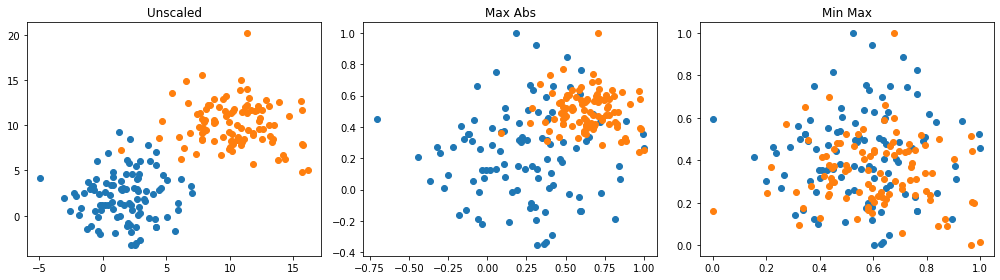

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MaxAbsScaler, minmax_scale

# for reproducibility
np.random.seed(42) 

# unscaled
std = 7
X = np.random.multivariate_normal([2, 2], [[std, 0], [0, std]], 
                                  size=100)
Y = np.random.multivariate_normal([10, 10], [[std, 0], [0, std]], 
                                  size=100)

# scaler 1
scaler_ = MaxAbsScaler()
X_maxabs = scaler_.fit_transform(X) # separate scaling
Y_maxabs = scaler_.fit_transform(Y)

# scaler 2
X_norm = minmax_scale(X, feature_range=(0, 1), axis=0, copy=True)
Y_norm = minmax_scale(Y, feature_range=(0, 1), axis=0, copy=True)

# plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

axes[0].scatter(X[:, 0], X[:, 1])
axes[0].scatter(Y[:, 0], Y[:, 1])
axes[1].scatter(X_maxabs[:, 0], X_maxabs[:, 1])
axes[1].scatter(Y_maxabs[:, 0], Y_maxabs[:, 1])
axes[2].scatter(X_norm[:, 0], X_norm[:, 1])
axes[2].scatter(Y_norm[:, 0], Y_norm[:, 1])
axes[0].title.set_text('Unscaled')
axes[1].title.set_text('Max Abs')
axes[2].title.set_text('Min Max')

fig.tight_layout()

# Singular Vector Decomposition

---


### Setup

In [2]:
import os
import time
import json

import numpy as np
import pandas as pd

from datetime import datetime

start_time = time.time()
dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2021-01-16


### Load Data

In [3]:
def load_data(data):
    raw_path = os.path.join("data","1_raw")
    filename = ''.join([data, ".csv"])
    out_dfm = pd.read_csv(os.path.join(raw_path, filename))
    out_arr = np.array(out_dfm.iloc[:,0].ravel())
    return out_arr

X_train = load_data("X_train")
y_train = load_data("y_train")

# transform y_array into int type
y_train[y_train=='ham'] = 0
y_train[y_train=='spam'] = 1
y_train = y_train.astype('int')

### BoW and Tfidf

Here I clean and preprocess the data in two formats, a Bag-of-upto-Trigrams with 2,000 terms, and a Tfidf representation of the same.

In [4]:
import urlextract
from nltk.stem import WordNetLemmatizer

with open("contractions_map.json") as f:
    contractions_map = json.load(f)

url_extractor = urlextract.URLExtract()
lemmatizer = WordNetLemmatizer()

import custom.clean_preprocess as cp

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pipe = Pipeline([
    ('counter', cp.DocumentToNgramCounterTransformer(n_grams=3)),
    ('bot', cp.WordCounterToVectorTransformer(vocabulary_size=2000)),
    ('tfidf', TfidfTransformer(sublinear_tf=True))          
])

In [5]:
# Bag-of-Trigrams
X_trans_counter = pipe['counter'].fit_transform(X_train)
X_trans_bot = pipe['bot'].fit_transform(X_trans_counter)

# Tfidf
X_trans_tfidf = pipe.fit_transform(X_train)

### SVD


In [6]:
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip
from sklearn.preprocessing import MaxAbsScaler, minmax_scale

def perform_SVD(X, n_components=300):

    # transpose to a term-document matrix
    U, Sigma, VT = svds(X.asfptype().T, 
                        k=n_components)
    # reverse outputs
    Sigma = Sigma[::-1]
    U, VT = svd_flip(U[:, ::-1], VT[::-1])
    
    # transpose to get V
    V = VT.T
    
    # max abs scales so that the max val is 1
    # includes negative values though
    scaler = MaxAbsScaler()
    X_maxabs = scaler.fit_transform(V) 
    
    # min max scale fits the data between two vals, 0 and 1 in this case
    X_minmax = minmax_scale(V, feature_range=(0, 1), axis=0, copy=True)
    
    return V, X_maxabs, X_minmax

In [7]:
X_svd, X_maxabs, X_minmax = perform_SVD(X_trans_tfidf)

In [8]:
def get_df(X):
    df = pd.concat([pd.DataFrame(X), 
                    pd.DataFrame(y_train.T, columns=['y'])], 
                    axis=1)
    return df

X_svd_df = get_df(X_svd)
X_maxabs_df = get_df(X_maxabs)
X_minmax_df = get_df(X_minmax)

## Scatter plot of first few feature pairs in SVD

In [9]:
import matplotlib.pyplot as plt

def plot_scatter(a):
    """
    Plot consecutive pairs of features in SVD matrices
    """
    b, c, d = a+1, a+2, a+3
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
    # unscaled
    axes[0].scatter(X_svd_df.iloc[:,a:b][X_svd_df['y']==0], 
                    X_svd_df.iloc[:,c:d][X_svd_df['y']==0])                     
    axes[0].scatter(X_svd_df.iloc[:,a:b][X_svd_df['y']==1],
                    X_svd_df.iloc[:,c:d][X_svd_df['y']==1])
    # max abs
    axes[1].scatter(X_maxabs_df.iloc[:,a:b][X_maxabs_df['y']==0], 
                    X_maxabs_df.iloc[:,c:d][X_maxabs_df['y']==0])
    axes[1].scatter(X_maxabs_df.iloc[:,a:b][X_maxabs_df['y']==1], 
                    X_maxabs_df.iloc[:,c:d][X_maxabs_df['y']==1])
    # min max
    axes[2].scatter(X_minmax_df.iloc[:,a:b][X_minmax_df['y']==0], 
                    X_minmax_df.iloc[:,c:d][X_minmax_df['y']==0])
    axes[2].scatter(X_minmax_df.iloc[:,a:b][X_minmax_df['y']==1], 
                    X_minmax_df.iloc[:,c:d][X_minmax_df['y']==1])
    # titles
    axes[0].title.set_text('Unscaled')
    axes[1].title.set_text('Max Abs')
    axes[2].title.set_text('Min Max')
    
    fig.tight_layout()

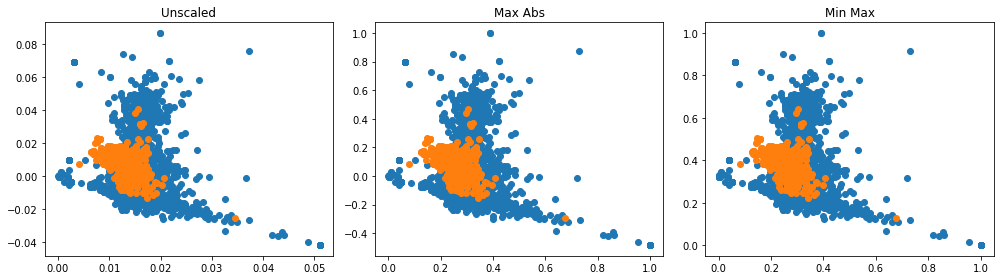

In [10]:
p = plot_scatter(0)

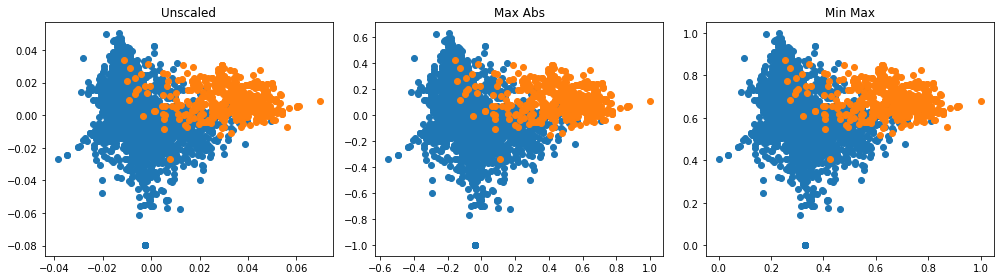

In [11]:
p = plot_scatter(1)

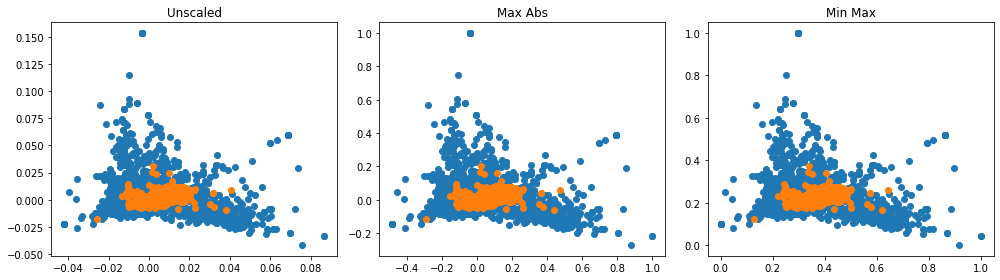

In [12]:
p = plot_scatter(2)

### Logistic Regression

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, recall_score

def scikitlearn_cv(clf, X, y, seed_, cv=5, test_size=.25):
    
    scorer_ = {
        'acc': make_scorer(accuracy_score),
        'tpr': make_scorer(recall_score, pos_label=1),
        'tnr': make_scorer(recall_score, pos_label=0)
    }
    
    acc = cross_val_score(clf, 
                          X, 
                          y, 
                          cv=cv, 
                          verbose=0, 
                          scoring=scorer_['acc'], 
                          n_jobs=-1)
    
    tpr = cross_val_score(clf, 
                          X, 
                          y, 
                          cv=cv, 
                          verbose=0, 
                          scoring=scorer_['tpr'], 
                          n_jobs=-1)
    
    tnr = cross_val_score(clf, 
                          X, 
                          y, 
                          cv=cv,
                          verbose=0, 
                          scoring=scorer_['tnr'], 
                          n_jobs=-1)
    
    return acc.mean(), tpr.mean(), tnr.mean()

In [14]:
def collect_cvs(clf, Xs, Xnames, y, seed_, cv=5, test_size=.25):
    
    s_accs, s_tprs, s_tnrs = [], [], []
    for X in Xs:
        s_acc, s_tpr, s_tnr = scikitlearn_cv(clf, 
                                             X, 
                                             y, 
                                             seed_=seed_, 
                                             cv=cv, 
                                             test_size=test_size)
        s_accs.append(round(s_acc, 4))
        s_tprs.append(round(s_tpr, 4))
        s_tnrs.append(round(s_tnr, 4))
    
    data = {'representation': Xnames,
            'mean_acc': s_accs, 
            'mean_tpr': s_tprs, 
            'mean_tnr': s_tnrs}
    
    return data

In [15]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(solver="liblinear", random_state=42)

Xs = [X_svd, X_maxabs, X_minmax]
Xnames = ['X_svd', 'X_maxabs', 'X_minmax']

data = collect_cvs(log_clf, Xs, Xnames, y_train, seed_=1209)

In [16]:
pd.DataFrame(data)

,representation,mean_acc,mean_tpr,mean_tnr
0,X_svd,0.8674,0.0000,1.0000
1,X_maxabs,0.9854,0.9032,0.9979
2,X_minmax,0.9828,0.8781,0.9988


The unscaled SVD predicts the ham base rate, which is why we geat 0% sensitivity and 100% specificity.

- This happens with logistic regression since the scale of the SVD is very close to 0, which is how ham was coded. This gets a good 85.7% accuracy since that is the proportion of ham to spam in our data

### Random Forests

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [18]:
def print_eval_metrics(y_val, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    print(f'accuracy: {acc:0.4f}')
    print(f'sensitivity: {tpr:0.4f}')
    print(f'specificity: {tnr:0.4f}')
    
def gridsearch_wrapper(Xs, Xnames, y, param_grid, k=10, n_jobs=6):
    """
    Performs grid searches and collects them in a list.
    Args:
        Xs: numeric matrices
        Xnames: their names
        y: the target
        k: the number of CV folds
        n_jobs: the number of logical cores
    """
    start_time = time.time()
    
    # instantiate list of dicts to gather results
    gridsearches = []
    for ix, X_name in enumerate(Xnames):

        X_ = Xs[ix]
        X_name = X_name.split('.')[0]

        # split into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X_, y, 
                                                          stratify=y)

        # setup scorers
        scorers = {
            'acc': make_scorer(accuracy_score),
            'tpr': make_scorer(recall_score, pos_label=1), 
            'tnr': make_scorer(recall_score, pos_label=0) 
        }

        # instantiate estimator
        clf = RandomForestClassifier(n_jobs=n_jobs, random_state=42)

        # instantiate k-fold gridsearch
        cv_folds = StratifiedKFold(n_splits=k)
    
        grid_search_clf = GridSearchCV(clf, 
                                       param_grid,
                                       scoring=scorers, 
                                       refit='tpr', 
                                       cv=cv_folds, 
                                       return_train_score=True, 
                                       n_jobs=n_jobs)
        
        # train models
        print(f'\nTraining {ix+1}: {X_name}...')
        start_gs = time.time()
        grid_search_clf.fit(X_train, y_train)
        elapsed_secs = time.time() - start_gs
        print(f'Elapsed: {elapsed_secs:0.0f} s')

        # predict
        y_pred = grid_search_clf.predict(X_val)
        print(f'Best params: {grid_search_clf.best_params_}')

        # confusion matrix on validation set
        print(f'Confusion matrix on validation set:')
        print(pd.DataFrame(confusion_matrix(y_val, y_pred),
                           columns=['pred_neg', 'pred_pos'],
                           index=['neg', 'pos']))
        # eval metrics
        print('Evaluation metrics:')
        print_eval_metrics(y_val, y_pred)

        data = {'representation':X_name,
                'gridsearch_res':grid_search_clf}
        
        # gather results into a list of dicts
        gridsearches.append(data)
        
    mins, secs = divmod(time.time() - start_time, 60)
    print(f'\nElapsed: {mins:0.0f} m {secs:0.0f} s')
    
    return gridsearches

In [21]:
param_grid = {  
    'n_estimators' : [50, 100],        # num trees is the main driver, but also expensive
    'max_features': [50, 75, 100],     # mtry in R, secondary driver, also expensive
    'min_samples_split': [5, 10],      # less is more expensive, but often better
    'max_depth': [3, 5, 10]            # deeper may be better, more expensive
}

In [22]:
grid_search_clf = gridsearch_wrapper(Xs, Xnames, y_train, param_grid, n_jobs=-1)


Training 1: X_svd...
Elapsed: 713 s
Best params: {'max_depth': 10, 'max_features': 100, 'min_samples_split': 10, 'n_estimators': 50}
Confusion matrix on validation set:
     pred_neg  pred_pos
neg       843         3
pos        17       112
Evaluation metrics:
accuracy: 0.9795
sensitivity: 0.8682
specificity: 0.9965

Training 2: X_maxabs...
Elapsed: 716 s
Best params: {'max_depth': 10, 'max_features': 100, 'min_samples_split': 5, 'n_estimators': 100}
Confusion matrix on validation set:
     pred_neg  pred_pos
neg       844         2
pos        20       109
Evaluation metrics:
accuracy: 0.9774
sensitivity: 0.8450
specificity: 0.9976

Training 3: X_minmax...
Elapsed: 719 s
Best params: {'max_depth': 10, 'max_features': 100, 'min_samples_split': 10, 'n_estimators': 100}
Confusion matrix on validation set:
     pred_neg  pred_pos
neg       840         6
pos        14       115
Evaluation metrics:
accuracy: 0.9795
sensitivity: 0.8915
specificity: 0.9929

Elapsed: 35 m 48 s


Of course I forgot to save the model and had a "workflow issue" so now I lost the output of the cell below. It was just a POC anyway, X_maxabs at the top with mid-80s TPR for what you'd expect, 100 trees, 100 features, etc.

In [ ]:
def extract_df(dic):
    df = pd.concat([
                    pd.DataFrame({'representation':[dic['representation']] \
                                * len(dic['gridsearch_res'].cv_results_["params"])}),
                    pd.DataFrame(dic['gridsearch_res'].cv_results_["params"]),
                    pd.DataFrame(dic['gridsearch_res'].cv_results_["mean_test_acc"],
                                 columns=["mean_val_acc"]),
                    pd.DataFrame(dic['gridsearch_res'].cv_results_["std_test_acc"],
                                 columns=["std_val_acc"]),
                    pd.DataFrame(dic['gridsearch_res'].cv_results_["mean_test_tpr"], 
                                 columns=["mean_val_tpr"]),
                    pd.DataFrame(dic['gridsearch_res'].cv_results_["std_test_tpr"], 
                                 columns=["std_val_tpr"]),
                    pd.DataFrame(dic['gridsearch_res'].cv_results_["mean_test_tnr"], 
                                 columns=["mean_val_tnr"]),
                    pd.DataFrame(dic['gridsearch_res'].cv_results_["std_test_tnr"], 
                                 columns=["std_val_tnr"])
                    ], axis=1)
    return df

# create list of dfs
df_list = []
for ix, dic in enumerate(grid_search_clf):
    df_list.append(extract_df(dic))

# flatten and reindex
dfm = pd.concat(df_list)
dfm.index = range(len(dfm))

# sort by top mean validation sensitivity
top_tpr = dfm.sort_values(by=['mean_val_tpr'], ascending=False).copy()

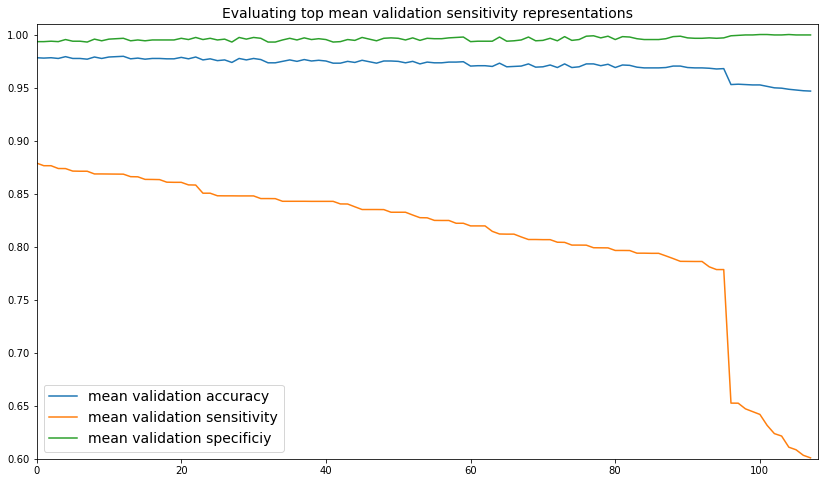

In [109]:
import matplotlib.pyplot as plt

def plot_topscores(X):
    plt.figure(figsize=(14, 8))
    plt.plot(np.array(X['mean_val_acc']), label="mean validation accuracy")
    plt.plot(np.array(X['mean_val_tpr']), label="mean validation sensitivity")
    plt.plot(np.array(X['mean_val_tnr']), label="mean validation specificiy")   
    plt.title('Evaluating top mean validation sensitivity representations', fontsize=14)
    plt.legend(loc="lower left", fontsize=14)
    plt.axis([0, len(top_tpr), 0.6, 1.01])
    plt.show()

plot_topscores(top_tpr)

The drop in sensitivity is proably due to a `max_depth=3`, `max_features=50` combination, with the final drop in number of trees:

In [110]:
top_tpr.tail(20)

,representation,max_depth,max_features,min_samples_split,n_estimators,mean_val_acc,std_val_acc,mean_val_tpr,std_val_tpr,mean_val_tnr,std_val_tnr
87,X_minmax,5,50,10,100,0.970264,0.009163,0.788799,0.067293,0.998030,0.001970
86,X_minmax,5,50,10,50,0.970259,0.009436,0.786167,0.073322,0.998422,0.002619
76,X_minmax,3,75,5,50,0.968888,0.010087,0.786100,0.073436,0.996847,0.003433
5,X_svd,3,75,5,100,0.968549,0.007127,0.786032,0.058806,0.996454,0.002756
7,X_svd,3,75,10,100,0.968549,0.007127,0.786032,0.058806,0.996454,0.002756
78,X_minmax,3,75,10,50,0.968206,0.009802,0.780972,0.074428,0.996849,0.003433
77,X_minmax,3,75,5,100,0.967522,0.008136,0.778408,0.069785,0.996454,0.003718
79,X_minmax,3,75,10,100,0.967862,0.009464,0.778408,0.076954,0.996847,0.003861
73,X_minmax,3,50,5,100,0.952830,0.013195,0.652497,0.094334,0.998819,0.002521
75,X_minmax,3,50,10,100,0.953171,0.012584,0.652429,0.089394,0.999213,0.001575


---